**Tutorial 4** : Neural Networks

Using data and example filters from the last tutorial, here several basic Neural Networks (NNs) are used to classify the data into different categories. Not all parameter combinations result in valid antenna designs, and the applied filters check minimal conditions to keep the tutorials brief.

NNs are a group of machine learning models inspired (and named after) the human brain. They have layers of interconnected nodes (neurons) that activate when set conditions are met. These networks are designed to recognize patterns. NNs have a training stage in order to train this pattern recognition.

NNS can be used in both supervised and unsupervised learning, depending on what task they are being applied to. In supervised learning, the NN is trained on labeled data (such as our data set) and the network learns to map inputs to specific outputs. During the supervised training process, the network makes predictions (the output) and compares these predictions to the labels (known 'ground truth' values). The error between the prediction and the labels are used to adjust weights (connections between layers and nodes). This is called backpropagation.

In unsupervised learning, the NN is trained on unlabeled data (or the labels are ignored) in order to find clusters or other relations between data.

<br>
<br>

There are 3 key components to structuring a neural network:

1) **The input layer**. This is where the input data is fed into the network. Each node is a feature of the input data.

2) **The hidden layer(s)**. NNs need at least one hidden, middle layer. This is the layer that process the data from the input layer and learn the patterns linked to identification in the output layer. There are different techniques to create the hidden layers, some of which will be discussed in this tutorial. Others are linked in the references.

3) **The output layer**. This is how the network produces its prediction. The prediction can be, for example, a class identifier (predicted antenna frequency) or a numerical value (predicted width). Even with highly accurate models, these outputs are called **predictions**.

<br><br>

In this tutorial series, several operations are performed using the W/L ratio of the rectangular patch. This is used as a shortcut for normalizing length and width parameters between frequencies for comparison. Data processing, filtering, and ML training does not need to use this as a standard.

While some preprocessing is necessary for machine learning in order to format data, this level of processing is not always needed. Typically, preprocessing must remove or handle missing data (NaNs, missing entries, improperly recorded data). For cleaner results, outliers should be detected and removed (especially in small sets), and some normalization may be needed depending on the data format. NNS tend to work better when data is normalized, especially when there is a large range of feature values. For instance, if one feature ranges from 0 to 0.5, while other features range from 0 to 500, then this may cause the smaller feature to be overshadowed in the training.


Demonstrated below are the following tasks:

* Importing the data from a .csv into a pandas dataframe
* Checking the dataframe for NAN or empty values
* Reading columns in the dataframe into a variable
* Filtering:
  * Removing rows with gain below a specific threshold
  * Removing rows with return loss above a specific threshold
  * Setting class labels based on target frequency values
* Neural Networks with supervised learning to predict target frequency based on width, length, and gain
  * One hidden layer
  * Multiple hidden layers
  * Confusion and accuracy testing





In Google Colab, you can mount your Google Drive to access and manipulate files stored in it.

You can either mount the drive manually, or execute the code below.

Adding manually:
1. Open a new or existing Colab notebook.
2. Click on the left-hand side of the screen to reveal the sidebar.
3. Click on the "Files" tab in the sidebar.
4. Click on the "Mount Drive" opion icon.

In [ ]:
# code for mounting the Google drive - remove this if running locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the libraries

In [ ]:
# for data and number manipulation
import pandas as pd
import numpy as np

# for visualization of data
import matplotlib.pyplot as plt


There is one, cleaned dataset included in the repository. These data have been sampled from the larger AntennaCAT set for the purpose of demonstration of machine learning techniques. The set is unbalanced, with 2 classes having ~10k samples, and the third having ~7k.

Data in these sets are all simulated with copper ground planes, copper conductors, and with FR4 substrate (permittivity: 4.4). The first row in the csv file is the labels for each column. Every row after that is data from one simulation.

In 'colab_dataset_microstrip', there are 27026 simulation entries with 13 columns.  The microstrip width is held constant at 3 mm for a 50 ohm impedance match. The gap between the strip and the patch is held constant at 1 mm.

1. "target_freq": the target design frequency in Hz. There are 3 frequencies (classes): 1.5 GHz, 2.4 GHz, 5.8 GHz.
2. "\$width": the width of the patch in mm.
3. "\$length": the length of the patch in mm.
4. "\$depth": the depth of the substrate in mm.
5. "\$ground_plane": the value in mm for the length and width of the ground plane square.
6. "\$x_0": the notch depth/feed point of the patch in mm.
7. "max_total_gain": maximum total simulated gain in dB.
8. "max_total_directivity": maximum total simulated directivity in dB.
9. "min_s11_f": the frequency for the lowest return loss value in dB (does not need to be the target frequency). This is not necessarily the target or local resonance.
10. "min_s11_dB": the lowest return loss value in dB for the frequency above.
11. "s11_at_target": the value of the return loss at the target frequency in dB.
12. "local_resonance_f": the frequency of the closest resonance to the target resonance in Hz.
13. "local_resonance_dB": the return loss of the local resonance in dB.




In [ ]:
# an example path for google sheets. replace with your file location
filepath = "/content/drive/MyDrive/2024-URSI/colab_dataset_microstrip.csv"

# read in the file as 'dataset'
dataset = pd.read_csv(filepath)

Simulations were run based on a parameter sweep, so not all simulations result in a valid design. The automated simulation process did not filter out invalid designs.

Below, two types of filters are applied as an example. The gain and return loss are used to remove a majority of the dataset. Without further filtering, it is not a guarantee that the remaining simulations are valid antenna designs (e.g., efficiency is not considered).


In [ ]:
# get a unique list of the frequency values, these will be used to create the class labels
UniqueNames = dataset.target_freq.unique()
print(UniqueNames)

[1500000000 2400000000 5800000000]


In [ ]:
# filtering the dataset to remove designs with poor gain

threshold_1500MHz = 2 #2dB minimum gain
threshold_2400MHz = 2 #2dB minimum gain
threshold_5800MHz = 3 #3dB minimum gain

returnLossdB = -10 #IEEE standard dB, 90% power transmission

# use the unique names to split up the data by frequency value
df1 = dataset[dataset['target_freq'] == 1500000000]
df2 = dataset[dataset['target_freq'] == 2400000000 ]
df3 = dataset[dataset['target_freq'] == 5800000000]

# use the threshold values to filter data by gain
df1_filtered = df1[df1['max_total_gain'] >= threshold_1500MHz]
df2_filtered = df2[df2['max_total_gain'] >= threshold_2400MHz ]
df3_filtered = df3[df3['max_total_gain'] >= threshold_5800MHz]

# use the threshold values to filter data by return loss
df1_filtered = df1_filtered[df1_filtered['s11_at_target'] <= returnLossdB]
df2_filtered = df2_filtered[df2_filtered['s11_at_target'] <= returnLossdB ]
df3_filtered = df3_filtered[df3_filtered['s11_at_target'] <= returnLossdB]

# print the length of the three dataframes
print(len(df1_filtered))
print(len(df2_filtered))
print(len(df3_filtered))

# split the data to make graphing easier
df1_w = df1_filtered['$width'].to_numpy()
df1_l = df1_filtered['$length'].to_numpy()
df1_s11 = df1_filtered['s11_at_target'].to_numpy() # return loss in (negative) dB at target frequency
df1_maxGain = df1_filtered['max_total_gain'].to_numpy()

df2_w = df2_filtered['$width'].to_numpy()
df2_l = df2_filtered['$length'].to_numpy()
df2_s11 = df2_filtered['s11_at_target'].to_numpy() # return loss in (negative) dB at target frequency
df2_maxGain = df2_filtered['max_total_gain'].to_numpy()

df3_w = df3_filtered['$width'].to_numpy()
df3_l = df3_filtered['$length'].to_numpy()
df3_s11 = df3_filtered['s11_at_target'].to_numpy() # return loss in (negative) dB at target frequency
df3_maxGain = df3_filtered['max_total_gain'].to_numpy()


328
250
291


The code blocks below create the following graphs from the last tutorial:
  * Frequency (classes labeled) vs. return loss at target (dB)
  * W/L (classes labeled) vs. max total gain (dB)


In the first graph, note that the data is not linearly separable. That is, a large amount of the data clusters overlap in a way that is not possible to separate with the plotted information.

However, the data in the second graph is linearly separable.


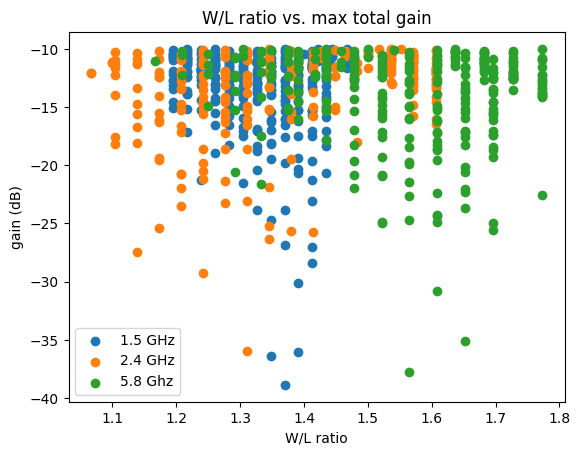

In [ ]:
# graph each class with a different color on the same plot
plt.scatter(df1_w/df1_l, df1_s11)
plt.scatter(df2_w/df2_l, df2_s11)
plt.scatter(df3_w/df3_l, df3_s11)

plt.title("W/L ratio vs. max total gain")
plt.xlabel("W/L ratio")
plt.ylabel("gain (dB)")
plt.legend(['1.5 GHz', '2.4 GHz', '5.8 Ghz'])


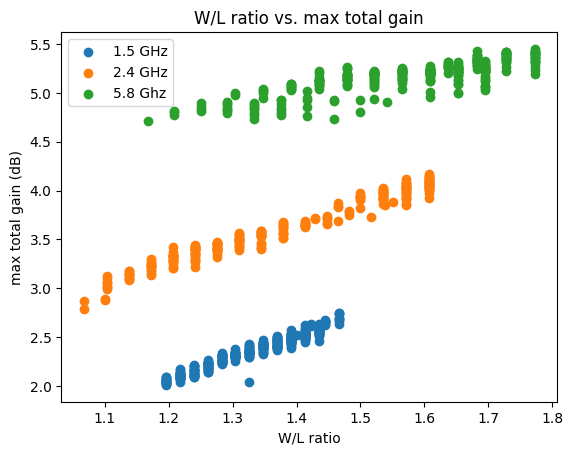

In [ ]:
# W/L (classes labeled) vs. max total gain (dB)
plt.scatter(df1_w/df1_l, df1_maxGain)
plt.scatter(df2_w/df2_l, df2_maxGain)
plt.scatter(df3_w/df3_l, df3_maxGain)
plt.title("W/L ratio vs. max total gain")
plt.xlabel("W/L ratio")
plt.ylabel("max total gain (dB)")
plt.legend(['1.5 GHz', '2.4 GHz', '5.8 Ghz'])


The following examples uses the singular case of W/L Ratio vs. Gain.

Rather than using both examples from above, only the 'W/L Ratio vs. Gain' data is used because it is the one of the two that is linearly separable. This is was important in tutorial 3 because support vector machines (SVMs) aim to find the optimal hyperplane that separates data points into different classes with the largest possible margin, thereby maximizing the generalization ability of the model. In this tutorial, linear separability makes it possible to use lower-dimensional NNs in order to classify data. This is more important as an example than it is in practical use. However, it is important to recognize that for more complex problems, broader and deeper NNs may be necessary for any kind of classification.


There are several important terms to know when experimenting with NNs.

1. **Features**: Features are the individual characteristics of the data (e.g., W, L, f, h) used as input to a model. They represent the measured or known attributes that the NN can use to make predictions about the data.

2. **Input**: The input refers to the data fed into a ML model or NN for processing. In supervised learning, inputs typically consist of the features of your data.

3. **Training**:  Training is the process where a machine learning model learns from data by adjusting its parameters (such as weights in a neural network). During training, the model is provided with labeled data (input-output pairs), and it adjusts to minimize the error between its predictions and the actual outcomes (using algorithms like gradient descent).

4. **Forward Propagation**:  Forward propagation is the process of passing input data through a neural network from the input layer to the output layer, layer by layer. In this process, the data is transformed by weights, biases, and activation functions to produce an output (or prediction). The NN model (or structure) is not updated at this step.

5. **Weights**: Control how much influence each input has on the output. Each connection moving forward in the network has a weight. These weights control the influence of each connection between neurons.

6. **Bias**: Bias values are generally optional. They are similar to weights, but rather than being a connection between neurons, they are a direct input to a neuron. These values add a numerical constant adjustment to the weighted sum of inputs.

7. **Activation Function**: Each neuron has an activation function that decides if that neuron 'fires', or activated. If the input to the neuron is below the threshold needed for activation, then the neuron's output is a 0 (or other value that indicates the neuron was not activated). These also introduce non-linearity, enabling neural networks to learn complex patterns in data.

8. **Predictions**: Predictions are the outputs generated by a model after processing the input data through the forward propagation process. In supervised learning, the predictions are the model’s estimated values or class labels for the given input. Even in highly accurate models, the output is referred to as a prediction as there is always a percentage of uncertainty for misclassification.

9. **Backpropagation**: Backpropagation is a key technique used for training neural networks. It is the process of computing the loss function (or gradient of difference between prediction and label), with respect to the network’s weights and biases, and then updating those weights to minimize the error. It works by calculating the error at the output, then propagating it backward through the network to adjust the weights.




Below is a simplified example using numpy (NP) rather than a ML specific library. This is intended to contextualize several parts of a neural network in the definitions above before using the imported dataset.

This example has an explicit activation function (a simple sigmoid) and uses a simple array of inputs with 3 features. The input and output have been hardcoded.



In [ ]:
import numpy as np

# Activation function: Sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of Sigmoid
def sigmoid_derivative(x):
    return x * (1 - x)



# Example input (3 features) and output (1 target)
# The input and output arrays have been split into 'inputs' and 'outputs'
#   to make it clear how they are grouped

# The input has 4 data points, with 3 features each.
# We do not have an explicit label for these, but they could be:
#   *  classifications (True/False)
#   *  Normalized input
#   *  Integer value entries
inputs = np.array([[0, 0, 1],
                   [1, 0, 1],
                   [0, 1, 1],
                   [1, 1, 1]])

# True outputs for the dataset (Target)
# These values are our 'target' values that we want the network to predict.
# In some cases these could be numerical forms of classification labels, such
# as splitting the data into 2 classes (0 and 1) to represent a string numerically.
outputs = np.array([[0], [1], [1], [0]])

# Number of neurons in each layer
input_layer_size = 3  # 3 inputs. 1 input per feature we are using
hidden_layer_size = 4 # 4 neurons in hidden layer
output_layer_size = 1 # 1 output. 1 output per feature we are predicting

# Initialize weights with random values
np.random.seed(42)  # For reproducibility

weights_input_hidden = np.random.rand(input_layer_size, hidden_layer_size)
weights_hidden_output = np.random.rand(hidden_layer_size, output_layer_size)

# Initialize biases
bias_hidden = np.random.rand(1, hidden_layer_size)
bias_output = np.random.rand(1, output_layer_size)

# Learning rate
# a float value used to control the learning rate,
# which is the balance between the old and new training iteration
learning_rate = 0.1

# Training process (e.g., 10000 iterations)
# an epoch is the number of training iterations.
for epoch in range(10000):
    # Forward pass
    hidden_layer_input = np.dot(inputs, weights_input_hidden) + bias_hidden
    hidden_layer_output = sigmoid(hidden_layer_input)

    final_input = np.dot(hidden_layer_output, weights_hidden_output) + bias_output
    final_output = sigmoid(final_input)

    # Compute the error (Mean Squared Error)
    error = outputs - final_output
    loss = np.mean(np.square(error))

    # Backpropagation
    # Calculate gradients for output layer
    output_error_term = error * sigmoid_derivative(final_output)

    # Calculate gradients for hidden layer
    hidden_error_term = output_error_term.dot(weights_hidden_output.T) * sigmoid_derivative(hidden_layer_output)

    # Update weights and biases
    weights_hidden_output += hidden_layer_output.T.dot(output_error_term) * learning_rate
    bias_output += np.sum(output_error_term, axis=0, keepdims=True) * learning_rate

    weights_input_hidden += inputs.T.dot(hidden_error_term) * learning_rate
    bias_hidden += np.sum(hidden_error_term, axis=0, keepdims=True) * learning_rate

    # Optionally print the loss every 1000 iterations to see progress
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

# After training, print the final output
print("Final output after training:")
print(final_output)

#'''
#The loss is calculated as the Mean Square Error (MSE), or average square of errors,
#which is a common way of calculating the difference between prediction and target.
#MSE is favored because it places less weight on outlier results.
#
#The final output after training is a float-value prediction. Depending on the bias,
#number of epochs, and training results, it is likely between 0 and 1. The value can
#be converted to an integer (0 or 1) to match the larget label, but this is a good example
#of how prediction results may need to be interpreted from the output.
#'''


Epoch 0, Loss: 0.3696963110374336
Epoch 1000, Loss: 0.24928933798243053
Epoch 2000, Loss: 0.2452316605639955
Epoch 3000, Loss: 0.22062050475431488
Epoch 4000, Loss: 0.1671990282942801
Epoch 5000, Loss: 0.1443001412570027
Epoch 6000, Loss: 0.13028950931599337
Epoch 7000, Loss: 0.037815458003343405
Epoch 8000, Loss: 0.015872929691147394
Epoch 9000, Loss: 0.009423151474252359
Final output after training:
[[0.04906669]
 [0.91012516]
 [0.92632442]
 [0.10088989]]


'\nThe loss is calculated as the Mean Square Error (MSE), or average square of errors, \nwhich is a common way of calculating the difference between prediction and target. \nMSE is favored because it places less weight on outlier results. \n\nThe final output after training is a float-value prediction. Depending on the bias,\nnumber of epochs, and training results, it is likely between 0 and 1. The value can\nbe converted to an integer (0 or 1) to match the larget label, but this is a good example\nof how prediction results may need to be interpreted from the output.\n'

The next example uses a common machine learning focused library. This is NOT the only library, but it is a popular one at the time of this tutorial.


<br>



**Step 1**: Import the libraries that will be used in this example

<br>
In previous examples, these have been imported as needed, but the individual examples in this tutorial are shorter, so for clarity all of the imports needed are shown below.


In [ ]:
 # A simple multi-layer perceptron neural network implementation in scikit-learn for classification tasks
from sklearn.neural_network import MLPClassifier

# The function for automating the data split
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# The functions used to evaluate how well the model performed
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix




**Step 2**: Set up the data for the NN for W, L, and Gain as Input, and Target Resonant Frequency as output.

<br>

The data needs to be zipped together such that the input to the network is an array of arrays. Each of the inner arrays is a collection of the inputs to the NN.

For the sake of demonstration, the data will be recombined with the following process:

* INPUT DATA:
  * Stack w, l, and the max total gain together

* CLASSIFICATION:
  * Convert the numerical target frequency to a numerical class label. While the target frequency values could technically be used as labels, it is more conventional to label in the form of class '1, 2, 3', than using irregularly spaced values (15000000000, 24000000000, 58000000000).


In [ ]:
# setting up the input data
# combine the 3 input params for each frequency
df1_input = np.dstack((df1_w, df1_l, df1_maxGain))[0]

df2_input = np.dstack((df2_w, df2_l, df2_maxGain))[0]

df3_input = np.dstack((df3_w, df3_l, df3_maxGain))[0]

# combine all three frequencies into one list of inputs
df_input = np.concatenate((df1_input, df2_input, df3_input))


print(len(df1_input))
print(len(df2_input))
print(len(df3_input))
print(len(df_input))


# print some samples
print(df1_input[0])
print(df1_input[10])
print(df2_input[0])
print(df2_input[10])
print(df3_input[0])
print(df3_input[10])



328
250
291
869
[55.      46.       2.05836]
[55.      46.       2.03815]
[32.      29.       3.10236]
[33.      29.       3.12719]
[14.      12.       4.71032]
[15.5     11.5      5.03671]


In [ ]:
# setting up the output data
# create arrays classification labels for the target frequencies
df1_labels = [1] * len(df1_filtered) # class 1 = 1.5 GHz
df2_labels = [2] * len(df2_filtered) # class 2 = 2.4 GHz
df3_labels = [3] * len(df3_filtered) # class 3 = 5.8 GHz
# combine all three frequencies into one list of labels
df_labels = np.concatenate((df1_labels, df2_labels, df3_labels))


print(len(df1_labels))
print(len(df2_labels))
print(len(df3_labels))
print(len(df_labels))



328
250
291
869


**Step 3**: Split the data into a 'train' set and a 'test' set to automate the validation process. Rather than testing the predictions on arbitrary values, this will allow for proper validation with known values.

<br>
The train_test_split() function takes in the combined input and output values. The test_size variable is a float between 0 and 1 that determines how much of the data is set aside for testing (validation). Setting a random_state value makes this example repeatable.


In [ ]:
# split the data from the previous examples into train and test
# to keep the varaible names readable, the notation switches here from 'df_input' and 'df_labels'
# to the more common 'X' and 'y', where 'X' denotes the input and 'y' is the labels
X_train, X_test, y_train, y_test = train_test_split(df_input, df_labels, test_size=0.33, random_state=42)

# print the sizes of the split
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

# print the test set labels. note that they have been randomized
print(y_test)

582
582
287
287
[2 1 2 1 3 3 1 3 3 2 1 2 2 1 2 1 2 3 1 2 1 2 1 2 2 1 1 1 1 3 3 2 3 3 3 2 3
 1 3 2 3 3 2 1 3 1 1 2 3 3 1 3 3 3 1 3 3 1 2 1 2 1 1 3 3 3 1 2 2 2 1 3 1 3
 1 1 3 1 1 3 1 3 3 1 2 3 2 3 1 1 3 1 1 2 3 2 1 3 3 3 1 1 3 3 1 3 2 2 3 1 2
 3 2 2 2 2 1 1 3 3 2 3 2 3 3 1 2 1 1 1 3 2 1 1 1 1 1 1 2 1 1 2 2 1 1 2 1 1
 1 2 3 3 2 1 1 1 1 2 3 2 1 3 3 1 3 2 3 3 2 1 2 2 2 2 3 3 2 2 3 2 3 3 2 1 2
 2 1 2 1 2 1 2 1 2 2 2 1 1 1 1 3 2 3 1 3 3 3 1 3 2 2 2 2 3 1 2 1 1 2 2 3 2
 1 3 3 1 2 1 2 1 2 3 2 1 2 1 3 2 3 3 3 1 1 1 3 2 2 2 2 3 3 3 3 1 3 2 3 1 3
 1 3 1 1 1 2 1 1 1 2 1 2 2 2 1 1 1 3 2 1 3 3 2 1 1 1 2 2]


**Step 4**: Create a NN classifier using the MLPClassifier function


<br>

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html


The MLPClassifier() is named after the Multi-layer Perceptron (MLP) classifier. These were the earliest forms of artificial neurons. More information about this can be found in the references.


<br>

This is step is where the examples will differ. First, we will create a single hidden layer NN.


In [ ]:
# Create a neural network classifier (MLP)
#  with 1 hidden layer and 5 neurons in that layer
clf = MLPClassifier(hidden_layer_sizes=(5,), max_iter=1000, random_state=42)



**Step 5**: Train the model with the training data

<br>
This version will have a warning about the model not converging. This is due to there only being 1 hidden layer. Increase the number of iterations if needed. On this example data it does not perform poorly with 1000.

In [ ]:
# Train the model
clf.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(5,), max_iter=1000, random_state=42)

**Step 6**: Predict and evaluate the model

<br>
The model has been fit (or trained), so it can now be used to predict classes based on inputs.



In [ ]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

# Optionally, display the predictions and the true labels
print("\nPredictions vs True Labels:")
for pred, true in zip(y_pred, y_test):
    print(f"Predicted: {pred}, True: {true}")


Accuracy: 97.91%

Predictions vs True Labels:
Predicted: 2, True: 2
Predicted: 1, True: 1
Predicted: 2, True: 2
Predicted: 1, True: 1
Predicted: 3, True: 3
Predicted: 3, True: 3
Predicted: 1, True: 1
Predicted: 3, True: 3
Predicted: 3, True: 3
Predicted: 2, True: 2
Predicted: 1, True: 1
Predicted: 2, True: 2
Predicted: 1, True: 2
Predicted: 1, True: 1
Predicted: 2, True: 2
Predicted: 1, True: 1
Predicted: 2, True: 2
Predicted: 3, True: 3
Predicted: 1, True: 1
Predicted: 2, True: 2
Predicted: 1, True: 1
Predicted: 2, True: 2
Predicted: 1, True: 1
Predicted: 2, True: 2
Predicted: 2, True: 2
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 3, True: 3
Predicted: 3, True: 3
Predicted: 2, True: 2
Predicted: 3, True: 3
Predicted: 3, True: 3
Predicted: 3, True: 3
Predicted: 2, True: 2
Predicted: 3, True: 3
Predicted: 1, True: 1
Predicted: 3, True: 3
Predicted: 2, True: 2
Predicted: 3, True: 3
Predicted: 3, True: 3
Predicted: 2, True: 2
Predicte


Input values can also be manually tested.

In [ ]:
# test manually with values from each class

wInput = 55
lInput = 46
gainInput = 2.058
pred = clf.predict([[wInput, lInput, gainInput]])
print(pred) #predicts class 1, or 1.5 GHz

wInput = 32
lInput = 29
gainInput = 3.4
pred = clf.predict([[wInput, lInput, gainInput]])
print(pred) #predicts class 2, or 2.4 GHz

wInput = 14
lInput = 12
gainInput = 4.7
pred = clf.predict([[wInput, lInput, gainInput]])
print(pred) #predicts class 3, or 5.8 GHz



[1]
[2]
[3]


In the cells below are two examples of how to validate a model's performance. Validating a machine learning model is crucial to ensure its performance and generalization ability.

Simple accuracy will tell you how well your model performs, but does not provide the whole picture. In this case, because there are only a few classes (3), we can use a confusion matrix to view how classes were positively or negatively predicted.

A confusion matrix is a table often used to describe the performance of a classification model on a set of test data for which the true values are known. It allows visualization of the performance, particularly in terms of binary classification, where there are few possible classes.

In a confusion matrix:

* Each row represents the instances in a predicted class.
* Each column represents the instances in an actual class (or vice versa)

In our example, with three classes, the matrix would resemble the following:

```
                   Actual Class 0   Actual Class 1   Actual Class 2
Predicted Class 0        TN_0              FP_0              FP_0
Predicted Class 1        FN_1              TP_1              FP_1
Predicted Class 2        FN_2              FN_2              TP_2

```
Where TN, FP, FN, and TP are:
* TN (True Negative): The number of correctly predicted negative instances.
* FP (False Positive): The number of incorrectly predicted positive instances.
* FN (False Negative): The number of incorrectly predicted negative instances.
* TP (True Positive): The number of correctly predicted positive instances.


The diagonals represent correct predictions for each class, while off-diagonal elements represent misclassifications.


In [ ]:
# make predictions using the test set
y_pred = clf.predict(X_test)


In [ ]:
# Calculate accuracy
# * compares the true labels with the predicted labels and returns
# the accuracy score, which is the fraction of correctly classified samples
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9790940766550522


In [ ]:
# Calculate the confusion matrix of predicted vs actual values
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)



Confusion Matrix:
[[107   0   0]
 [  6  85   0]
 [  0   0  89]]


**Further Examples**:

Using multiple hidden layers and changing the number of neurons.

<br>

Note that changing the number of layers and the number of neurons has a strong
impact on the accuracy.

Accuracy under 95% is generally undertrained, while accuracy of 100 is almost always overtrained.



In [ ]:

# Create a neural network classifier (MLP)
#  with 3 hidden layers with and 5 neurons, 12 neurons, and 3 neurons
clf = MLPClassifier(hidden_layer_sizes=(5, 12, 3), max_iter=1000, random_state=42)


# Train the model
clf.fit(X_train, y_train)

# make predictions on the test set and save it as y+pred
y_pred = clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

# # Optionally, display the predictions and the true labels
# print("\nPredictions vs True Labels:")
# for pred, true in zip(y_pred, y_test):
#     print(f"Predicted: {pred}, True: {true}")

# Calculate accuracy
# * compares the true labels with the predicted labels and returns
# the accuracy score, which is the fraction of correctly classified samples
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Calculate the confusion matrix of predicted vs actual values
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)


Accuracy: 68.29%
Accuracy: 0.6829268292682927
Confusion Matrix:
[[107   0   0]
 [  0   0  91]
 [  0   0  89]]


In [ ]:
# Create a neural network classifier (MLP)
#  with 3 hidden layers with and 5 neurons, 12 neurons, and 5 neurons
clf = MLPClassifier(hidden_layer_sizes=(5, 12, 5), max_iter=1000, random_state=42)


# Train the model
clf.fit(X_train, y_train)

# make predictions on the test set and save it as y+pred
y_pred = clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

# # Optionally, display the predictions and the true labels
# print("\nPredictions vs True Labels:")
# for pred, true in zip(y_pred, y_test):
#     print(f"Predicted: {pred}, True: {true}")

# Calculate accuracy
# * compares the true labels with the predicted labels and returns
# the accuracy score, which is the fraction of correctly classified samples
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Calculate the confusion matrix of predicted vs actual values
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)


Accuracy: 100.00%
Accuracy: 1.0
Confusion Matrix:
[[107   0   0]
 [  0  91   0]
 [  0   0  89]]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Create a neural network classifier (MLP)
#  with 1 hidden layer with and 12 neurons
clf = MLPClassifier(hidden_layer_sizes=(12), max_iter=1000, random_state=42)


# Train the model
clf.fit(X_train, y_train)

# make predictions on the test set and save it as y+pred
y_pred = clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

# # Optionally, display the predictions and the true labels
# print("\nPredictions vs True Labels:")
# for pred, true in zip(y_pred, y_test):
#     print(f"Predicted: {pred}, True: {true}")

# Calculate accuracy
# * compares the true labels with the predicted labels and returns
# the accuracy score, which is the fraction of correctly classified samples
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Calculate the confusion matrix of predicted vs actual values
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)


Accuracy: 100.00%
Accuracy: 1.0
Confusion Matrix:
[[107   0   0]
 [  0  91   0]
 [  0   0  89]]
